In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


# **Important Libraries**

In [2]:
# Important Libraries
import string
import numpy as np
import re
import unicodedata
import html
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding,Dense,LSTM, Dropout,GRU,Bidirectional
import subprocess
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('omw-1.4')
# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /kaggle/working/...


# **Load Dataset**

In [3]:
#Load the data
columns = ['id','land','Label','Text']
df=pd.read_csv(r'/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv',index_col=0,names= columns)

# Reset index
df.reset_index(drop=True, inplace=True)

print(f'Rows: {df.shape[0]},columns: {df.shape[1]}')
df.head()

Rows: 74682,columns: 3


,land,Label,Text
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


# **EDA**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   land    74682 non-null  object
 1   Label   74682 non-null  object
 2   Text    73996 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [5]:
df.dropna(inplace=True)

In [6]:
df.isna().sum()

land     0
Label    0
Text     0
dtype: int64

In [7]:
df.duplicated().sum()

3038

In [8]:
df.drop_duplicates(inplace=True)

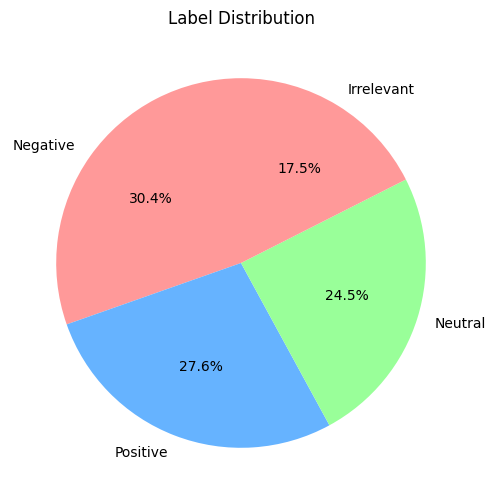

In [9]:
# Overall Label distribution
label_counts = df['Label'].value_counts()

plt.figure(figsize=(6, 6))
label_counts.plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'], startangle=90)
plt.title("Label Distribution")
plt.ylabel("")  # Remove y-axis label
plt.show()

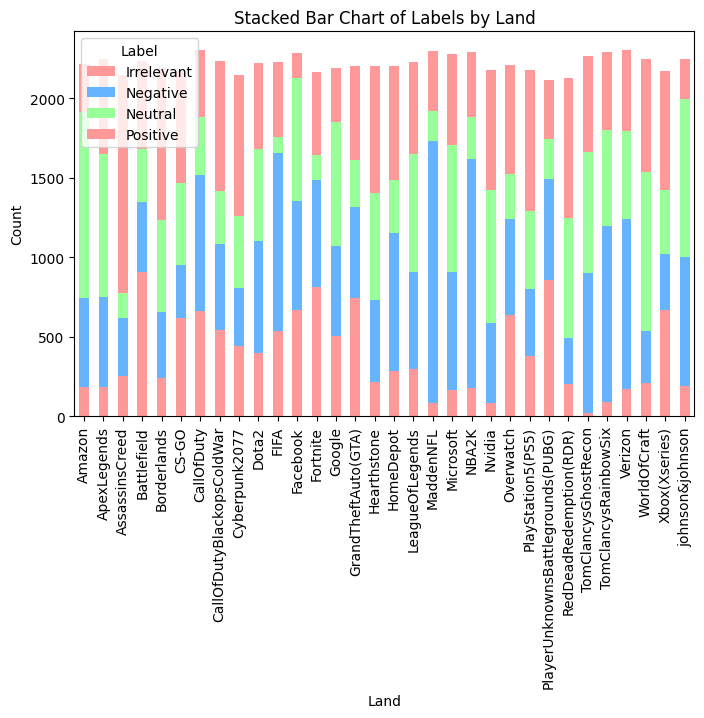

In [10]:
# Prepare data for stacked bar chart
land_label_counts = df.groupby(['land', 'Label']).size().unstack(fill_value=0)

# Plot
land_label_counts.plot(kind='bar', stacked=True, figsize=(8, 5), color=['#ff9999','#66b3ff','#99ff99'])
plt.title("Stacked Bar Chart of Labels by Land")
plt.xlabel("Land")
plt.ylabel("Count")
plt.legend(title="Label")
plt.show()


# **Spliting and Preprocessing**

In [11]:
X=df['Text']
y=df['Label'].map({'Neutral': 1, 'Negative': 0,'Positive':2,'Irrelevant':1})

In [12]:
def normalize_text(text):
    """
    Normalize text for sentiment analysis by retaining sentiment-bearing features like emojis,
    negations, and tone indicators while cleaning unnecessary elements.
    :param text: Input text to be normalized
    :return: Normalized text as a string
    """
    # Initialize lemmatizer and tokenizer
    lemmatizer = WordNetLemmatizer()
    tokenizer = TweetTokenizer()

    # Custom stopwords list (excluding negations and sentiment-bearing words)
    stop_words = set(stopwords.words('english')) - {'not', 'no', 'never', 'nor', 'none', 'nothing', 'neither'}

    # Replace HTML entities and special characters
    text = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'") \
        .replace('nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'") \
        .replace('<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.') \
        .replace(' @-@ ', '-').replace('\\', ' \\ ')
    text = re.sub(r'  +', ' ', html.unescape(text))

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove emails
    text = re.sub(r'\S+@\S+\.\S+', '', text)

    # Map emojis to their textual equivalents
    text = emoji.demojize(text, delimiters=(" ", " "))

    # Remove non-ASCII characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Tokenize the text
    words = tokenizer.tokenize(text)

    # Remove stopwords (excluding negations)
    words = [word for word in words if word not in stop_words]

    # Lemmatize words (preserve sentiment-bearing words)
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]

    # Retain exclamation marks and question marks for tone
    words = [word for word in words if word not in string.punctuation or word in {'!', '?'}]

    return ' '.join(words)

In [13]:
# Preprocessing Text
X=X.apply(normalize_text)
X.head()

0      im get borderlands murder
1               come border kill
2        im get borderlands kill
3     im come borderlands murder
4    im get borderlands 2 murder
Name: Text, dtype: object

In [14]:
# Making Training and Testing
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56766,), (14192,), (56766,), (14192,))

# **GloVe**

In [15]:
y_train.unique()

array([1, 0, 2])

In [16]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2025-01-08 08:26:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-01-08 08:26:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-01-08 08:26:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [17]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [18]:
# Prepare tokenizer
t = Tokenizer(num_words=20000, oov_token="<OOV>")
t.fit_on_texts(X_train)
# Calculate vocabulary size
vocab_size = len(t.word_index) + 1
max_len=100
# Integer encode
encoded_train_docs = t.texts_to_sequences(X_train)
# Integer encode
encoded_test_docs = t.texts_to_sequences(X_test)

# Pad documents to a max length of 100 words
padded_train_docs = pad_sequences(encoded_train_docs, maxlen=max_len, padding='post')
padded_test_docs = pad_sequences(encoded_test_docs, maxlen=max_len, padding='post')

# Load the whole embedding into memory
embeddings_index = dict()
with open('glove.6B.100d.txt', mode='rt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f'Loaded {len(embeddings_index)} word vectors.')

# Create a weight matrix for words
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


# **LSTM Model**

In [20]:
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       2,883,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,883,600 (11.00 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,883,600 (11.00 MB)

In [21]:
model.fit(padded_train_docs, y_train, epochs=10, verbose=1,validation_split=0.2)

Epoch 1/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.5393 - loss: 0.9355 - val_accuracy: 0.6354 - val_loss: 0.8010
Epoch 2/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.6460 - loss: 0.7766 - val_accuracy: 0.6450 - val_loss: 0.7653
Epoch 3/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 52s 37ms/step - accuracy: 0.7052 - loss: 0.6725 - val_accuracy: 0.7289 - val_loss: 0.6276
Epoch 4/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 52s 37ms/step - accuracy: 0.7993 - loss: 0.4882 - val_accuracy: 0.7883 - val_loss: 0.5196
Epoch 5/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 52s 37ms/step - accuracy: 0.8636 - loss: 0.3392 - val_accuracy: 0.8265 - val_loss: 0.4536
Epoch 6/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 52s 37ms/step - accuracy: 0.9009 - loss: 0.2537 - val_accuracy: 0.8475 - val_loss: 0.4267
Epoch 7/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 52s 37ms/step - accuracy: 0.9275 - loss: 0.1869 - val_accuracy: 0.8575 - val_loss: 0.4058
Epoch 8/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 52s 37ms/step - accuracy: 0.9381 -

In [22]:
# Get Predictions
y_pred = np.argmax(model.predict(padded_test_docs), axis=1)
# Evaluate model
loss, accuracy = model.evaluate(padded_test_docs, y_test, verbose=0)
print(f'Test Accuracy: {(accuracy)}, Loss: {loss}')

444/444 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
Test Accuracy: 0.8554114699363708, Loss: 0.48141640424728394


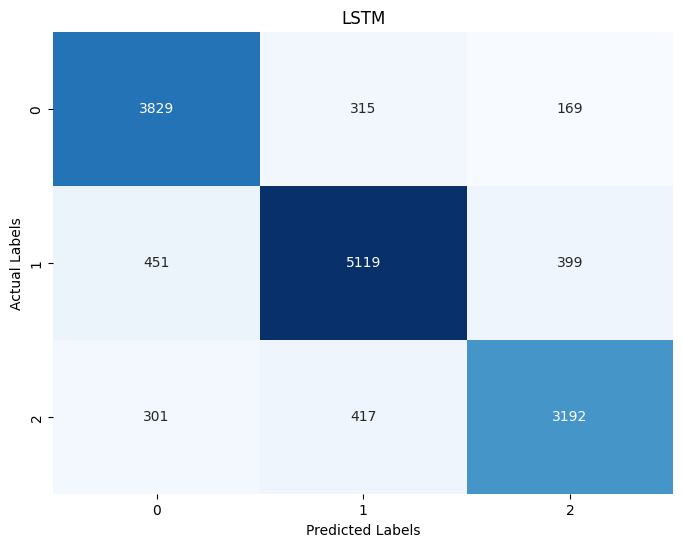

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('LSTM')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# **GRU Model**

In [24]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
model2.add(Bidirectional(GRU(256, return_sequences=True)))
model2.add(Dropout(0.3)) 
model2.add(Bidirectional(GRU(256)))
model2.add(Dropout(0.3)) 
model2.add(Dense(3, activation='softmax'))
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       2,883,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,883,600 (11.00 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,883,600 (11.00 MB)

In [25]:
model2.fit(padded_train_docs, y_train, epochs=10,verbose=1,validation_split=0.2)

Epoch 1/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.5323 - loss: 0.9379 - val_accuracy: 0.6154 - val_loss: 0.8182
Epoch 2/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - accuracy: 0.6527 - loss: 0.7594 - val_accuracy: 0.7108 - val_loss: 0.6632
Epoch 3/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - accuracy: 0.7567 - loss: 0.5730 - val_accuracy: 0.7803 - val_loss: 0.5387
Epoch 4/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - accuracy: 0.8533 - loss: 0.3714 - val_accuracy: 0.8179 - val_loss: 0.4746
Epoch 5/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - accuracy: 0.9026 - loss: 0.2416 - val_accuracy: 0.8408 - val_loss: 0.4404
Epoch 6/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - accuracy: 0.9270 - loss: 0.1831 - val_accuracy: 0.8412 - val_loss: 0.4647
Epoch 7/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - accuracy: 0.9397 - loss: 0.1503 - val_accuracy: 0.8486 - val_loss: 0.4586
Epoch 8/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - accuracy: 0.9486 -

In [26]:
# Predict and evaluate
y_pred = np.argmax(model2.predict(padded_test_docs), axis=1)
# Evaluate model
loss, accuracy = model2.evaluate(padded_test_docs, y_test, verbose=0)
print(f'Test Accuracy: {(accuracy)}, Loss: {loss}')

444/444 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
Test Accuracy: 0.8489994406700134, Loss: 0.5138368606567383


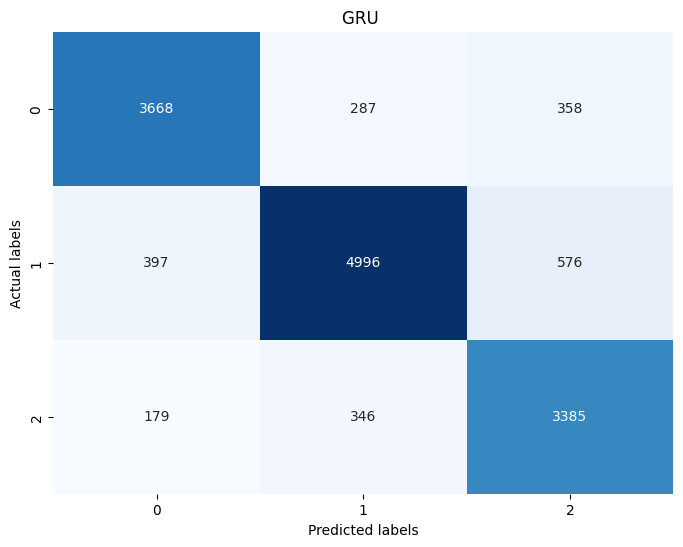

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('GRU ')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

# **RNN Model**

In [28]:
model3 = Sequential()
model3.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_len, trainable=False))
model3.add(Bidirectional(SimpleRNN(256, return_sequences=True)))
model.add(Dropout(0.3)) 
model3.add(Bidirectional(SimpleRNN(256)))
model.add(Dropout(0.3)) 
model3.add(Dense(3, activation='softmax'))
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │       2,883,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,883,600 (11.00 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,883,600 (11.00 MB)

In [29]:
model3.fit(padded_train_docs, y_train, epochs=10, verbose=1,validation_split=0.2)

Epoch 1/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 81s 53ms/step - accuracy: 0.4408 - loss: 1.0858 - val_accuracy: 0.4352 - val_loss: 1.0435
Epoch 2/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 73s 51ms/step - accuracy: 0.4805 - loss: 1.0088 - val_accuracy: 0.4967 - val_loss: 0.9836
Epoch 3/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 73s 51ms/step - accuracy: 0.4977 - loss: 0.9869 - val_accuracy: 0.5084 - val_loss: 0.9563
Epoch 4/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 73s 51ms/step - accuracy: 0.4928 - loss: 0.9931 - val_accuracy: 0.5048 - val_loss: 0.9793
Epoch 5/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 73s 51ms/step - accuracy: 0.4929 - loss: 0.9968 - val_accuracy: 0.5151 - val_loss: 0.9602
Epoch 6/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 73s 51ms/step - accuracy: 0.4955 - loss: 1.0024 - val_accuracy: 0.4903 - val_loss: 0.9960
Epoch 7/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 73s 51ms/step - accuracy: 0.5069 - loss: 0.9757 - val_accuracy: 0.5140 - val_loss: 0.9642
Epoch 8/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 73s 51ms/step - accuracy: 0.5095 -

In [30]:
# Predict and evaluate
y_pred = np.argmax(model3.predict(padded_test_docs), axis=1)
# Evaluate model
loss, accuracy = model3.evaluate(padded_test_docs, y_test, verbose=0)
print(f'Test Accuracy: {(accuracy)}, Loss: {loss}')

444/444 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step
Test Accuracy: 0.49859076738357544, Loss: 0.969475269317627


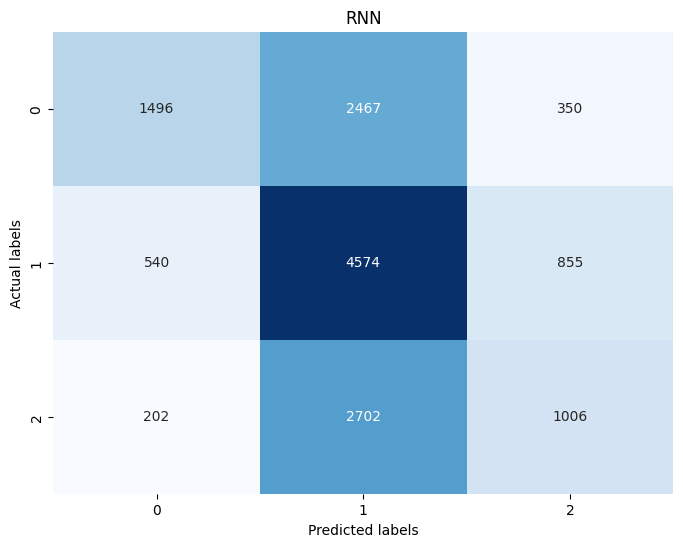

In [31]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('RNN')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()